# ECoG quality checks

This tutorial will showcase two ways to quality check the dataset. First, we will correlate the podcast audio with each electrode's time series. We expect that electrodes that are very close to the [primary auditory cortex](https://en.wikipedia.org/wiki/Auditory_cortex) will be correlated to the audio waveform (Honey et al., 2012). Second, we will use an [event-related potential](https://en.wikipedia.org/wiki/Event-related_potential) (ERP) analysis to see an electrode's response to the onset of a word.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hassonlab/podcast-ecog-tutorials/blob/main/notebooks/01-qualitychecks.ipynb)

In [ ]:
# only run this cell in colab
!pip install nilearn mne mne_bids scipy pandas matplotlib

In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile
from scipy.stats import pearsonr, zscore
from mne_bids import BIDSPath
from functools import partial
from nilearn.plotting import plot_markers

Just like the first tutorial, we will load the preprocessed neural activity in the high-gamma band for one subject using MNE.

In [2]:
bids_root = ""  # if using a local dataset, set this variable accordingly

file_path = BIDSPath(root=f"{bids_root}derivatives/ecogprep",
                    subject="03", task="podcast", datatype="ieeg", description="highgamma",
                    suffix="ieeg", extension=".fif")
print(f"File path within the dataset: {file_path}")

# You only need to run this if using Colab (i.e. if you did not set bids_root to a local directory)
if not len(bids_root):
    !wget -nc https://s3.amazonaws.com/openneuro.org/ds005574/$file_path
    file_path = file_path.basename

File path within the dataset: ../../monkey/derivatives/ecogprep/sub-03/ieeg/sub-03_task-podcast_desc-highgamma_ieeg.fif


However, this time after we read the file, we are going to select only a subset of electrodes. We do this simply to make the computations quicker and compatiable with fewer resources. The electrodes we chose to keep are known as "grid" electrodes because they're arranged as a grid on the brain. In this case, we know which electrodes these are because of their names: they either start with LGA or LGB.

In [3]:
raw = mne.io.read_raw_fif(file_path, verbose=False)
picks = mne.pick_channels_regexp(raw.ch_names, "LG[AB]*")
raw = raw.pick(picks)
raw

<Raw | sub-03_task-podcast_desc-highgamma_ieeg.fif, 235 x 921600 (1800.0 s), ~271 kB, data not loaded>

And then, we will extract the underlying data to use directly:

In [4]:
ecog_data = raw.get_data()
print(f"ECoG data has a shape of: {ecog_data.shape}")

ECoG data has a shape of: (235, 921600)


## Correlation between electrode activity and audio stimulus

Next, we will load the raw audio waveform of the podcast. Note that the audio has a different sampling rate than the ECoG data, thus has many more time points.

In [5]:
# Download the audio, if required
audio_path = f"{bids_root}stimuli/podcast.wav"
if not len(bids_root):
    !wget -nc https://s3.amazonaws.com/openneuro.org/ds005574/$audio_path
    audio_path = "podcast.wav"

In [6]:
audio_sf, audio_wave = wavfile.read(audio_path)

print(f"Audio waveform is sampled at {audio_sf} Hz and has a shape of: {audio_wave.shape}")

# We will arbitrarily select the first channel from the stereo audio
if audio_wave.ndim > 1:
    audio_wave = audio_wave[:, 0]

Audio waveform is sampled at 44100 Hz and has a shape of: (79380000, 2)


/tmp/ipykernel_3294141/641169259.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  audio_sf, audio_wave = wavfile.read(audio_path)


You can also listen to the first 30 seconds of the podcast:

In [7]:
from IPython.display import Audio
Audio(audio_wave[:audio_sf*30], rate=audio_sf)

Following the procedure in Honey et al., 2012, we will extract the power modulations from the raw waveform between 200 and 5000 Hz. Then, we downsample this new time-series to the same sampling rate as the ECoG data (512 Hz). The entire process is encapsulated in the following function. It is not critical for you to follow it closely if you are not familiar with digital signal processing.

In [8]:
def preprocess_raw_audio(x, fs, to_fs, lowcut=200, highcut=5000):

    # See https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
    def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = signal.butter(order, [low, high], btype="band")
        return b, a

    def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = signal.lfilter(b, a, data)
        return y

    assert x.ndim == 1

    # Step 1. Bandpass the high quality audio
    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=5)

    # Step 2. Downsample to same freq as clinical system
    # Number of new samples is N = n * (to_fs / fs)
    y = signal.resample(y, num=round(x.size / fs * to_fs))

    # Step 3. Take audio envelope
    envelope = np.abs(signal.hilbert(y - y.mean()))

    return envelope

Notice that after preprocessing, the audio power has a new sampling rate and the same number of samples as the ECoG data:

In [9]:
ecog_sr = raw.info['sfreq']
audio_power = preprocess_raw_audio(audio_wave, audio_sf, ecog_sr)

print(f"Audio power is sampled at {ecog_sr} Hz and has a shape of: {audio_power.shape}")

Audio power is sampled at 512.0 Hz and has a shape of: (921600,)


Now we have both time series that we want to correlate. We will loop through each electrode at a time, and correlate its neural activity with the audio power, saving the result in a list.

In [10]:
n_electrodes = ecog_data.shape[0]
correlations = np.zeros(n_electrodes)
for i in range(len(ecog_data)):
    result = pearsonr(audio_power, ecog_data[i])
    correlations[i] = result.statistic

Great! We computed the correlations, now what? Since we have one correlation per electrode, we can view the results directly on the brain. This way, we verify that electrodes located near the primary auditory cortex do show a higher correlation to the audio stimulus than other electrodes.

Coordinate matrix shape:  (235, 3)


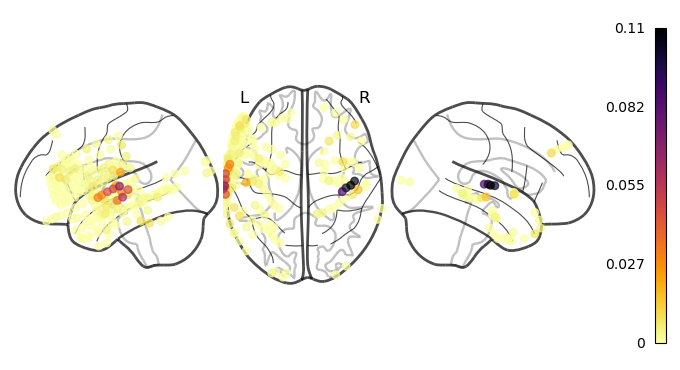

In [11]:
ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
coords *= 1000  # nilearn likes to plot in meters, not mm
print("Coordinate matrix shape: ", coords.shape)

# order will ensure that the highest correlations are plotted on top (last)
order = correlations.argsort()
plot_markers(correlations[order], coords[order],
             node_size=30, display_mode='lzr',
             node_vmin=0, node_cmap='inferno_r', colorbar=True)
plt.show()

This example made a strong simplifying assumption: that the audio and electrode activity are synchronized simulatenously. However, this does not need be true for all electrodes. There are some electrodes who will be processing the incoming signal and thus will have some delay. To account for this possiblity, a [cross correlation](https://en.wikipedia.org/wiki/Cross-correlation) analysis is particularily usseful.

## Event related potenial

This quality check tests how electrodes respond to the onset of words. For example, an electrode that is actively processing words may increase its activity whenever a word occurs. A general term for this kind of analysis is called event-related potentials. The idea behind it is straightforward. For each electrode, we will extract a window of its activity whenever a word occurs. So, if there 10 words and the window has 50 samples, we end up with a matrix of (10, 50) for one electrode. Then, we average over the words and keeping the time dimension intact. Now we have a 50-dimensional vector that summarizes the electrode's average response to a word occuring at a particular time point in the window we chose.

We already loaded the ECoG data, but for this analysis we also need the word-aligned transcript because we need to know the onset of each word. We use [pandas](https://pandas.pydata.org) to load this transcript as a DataFrame:

In [12]:
# Download the transcript, if required
transcript_path = f"{bids_root}stimuli/podcast_transcript.csv"
if not len(bids_root):
    !wget -nc https://s3.amazonaws.com/openneuro.org/ds005574/$transcript_path
    transcript_path = "podcast_transcript.csv"

In [13]:
df = pd.read_csv(transcript_path)
df.dropna(subset=['start'], inplace=True)
df.sort_values("start", inplace=True)
df.head(10)

word  start    end
0      Act  3.710  3.790
1     one,  3.990  4.190
2   monkey  4.651  4.931
3       in  4.951  5.011
4      the  5.051  5.111
5  middle.  5.151  5.391
6       So  6.592  6.732
7  there's  6.752  6.912
8     some  6.892  7.052
9   places  7.072  7.342

We will take advantage of MNE's [Epochs](https://mne.tools/stable/generated/mne.Epochs.html) class to extract the windows around word onsets (also called an _epoch_). To create an `Epochs` object, we must supply it with an `events` NumPy array. This array will have a row for each word, and 3 columns. In our case, we only need the fill in the first column, which corresponds to the onset of the word.

In [14]:
events = np.zeros((len(df), 3))
events[:, 0] = df.start
print(f"events array has a shape of: {events.shape}")

events array has a shape of: (5136, 3)


We pass the raw object and events data to Epochs and create the objet. Notice that the underlying data representing this object is a 3D array where the dimensions correspond to (number of words x number of electrodes x number of time points). We also apply a simple preprocessing step before creating the epochs. Because the neural activity of each electrode will have a different range, it simplifies our analysis to put them on the same scale. To do so, we [standarize](https://en.wikipedia.org/wiki/Standard_score) the data by `z-scoring`. This process will subtract the mean and divide by the standard deviation for each electrode time series (thus the mean of each electrode's time series will be 0 and its standard deviation will be 1).

In [15]:
# zscore the electrode time series so they're all on the same scale
func = partial(zscore, axis=1)
raw.load_data()
raw = raw.apply_function(func, channel_wise=False)

epochs = mne.Epochs(
    raw,
    (events * raw.info['sfreq']).astype(int),
    tmin=-0.5,
    tmax=1.5,
    baseline=None,
    proj=None,
    event_id=None,
    preload=True,
    event_repeated="merge",
)

print(f"Epochs object has a shape of: {epochs._data.shape}")

Reading 0 ... 921599  =      0.000 ...  1799.998 secs...
Not setting metadata
5136 matching events found
No baseline correction applied
Using data from preloaded Raw for 5136 events and 1025 original time points ...
5 bad epochs dropped
Epochs object has a shape of: (5131, 235, 1025)


A 3D array is a lot of data to work with. We can reduce the epochs data into an "evoked" response by averaging across the words. With MNE, this is performed by calling the `average()` method of the Epochs class, which will return an [Evoked](https://mne.tools/stable/generated/mne.Evoked.html) object. Notice the shape of this object's data:

In [16]:
evoked = epochs.average()
print(f"Evoked object has a shape of: {evoked.data.shape}")

Evoked object has a shape of: (235, 1025)


MNE also provides the ability to plot the averaged, evoked response of each electrode as seen below. Notice how some electrodes show an increase in activity at time point 0 (the onset of the word). While other electrodes do not.

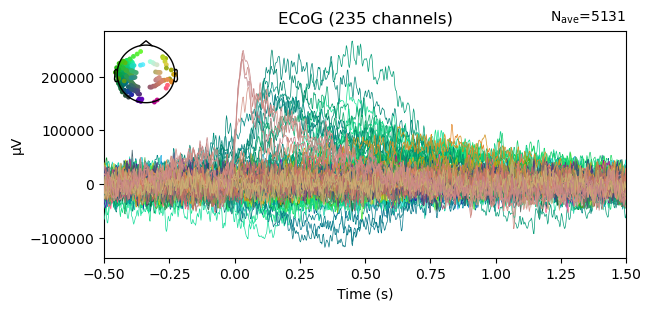

In [17]:
evoked.plot();

We can again plot on the brain this data. Because the evoked object has a shape of (number of electrodes x window time points), we need to reduce the time points dimension and retain one value per electrode. An easy computation to do for this visualization is to take the maximum value across the window.

Coordinate matrix shape:  (235, 3)


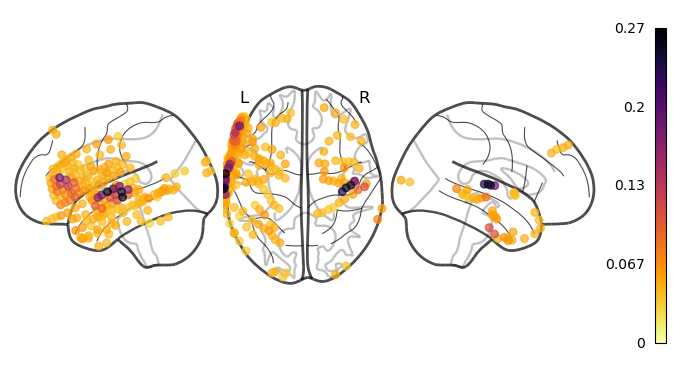

In [18]:
values = evoked.data.max(-1)

ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
coords *= 1000  # nilearn likes to plot in meters, not mm
print("Coordinate matrix shape: ", coords.shape)

order = values.argsort()
plot_markers(values[order], coords[order],
             node_size=30, display_mode='lzr',
             node_vmin=0, node_cmap='inferno_r', colorbar=True)
plt.show()

Again, as we expect, the electrodes closest to the primary auditory cortex are the ones that show the greatest increase in activity. However, we also see a few electrodes in the inferior frontal gyrus with higher activity.